# Feature selection
-----
- z-stack Movies were prepared from the merged tilescan images
- We are now ready for feature extraction from the movies


In [1]:
%matplotlib notebook

# Dependencies

import os
import cv2
import merging_functions as mf
import numpy as np
import tracker as tr

from matplotlib import pyplot as plt

In [2]:
# Go through each timepoint and each frame to collect the pixel and their locations that exceeds the threshold
def get_image_sequence(video_folder, exp_name, acq_name, t_str):
    # Run through a single timepoint
    video_path = os.path.join(video_folder, f"{exp_name}_{acq_name}_{t_str}.avi")

    # Video capture object
    vidcap = cv2.VideoCapture(video_path)

    # Frame properties
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

    img_seq = np.zeros((frame_height, frame_width, frame_count), np.uint8)
    for fix in range(frame_count):
        # Read frmae
        success,frame = vidcap.read()
        # Convert to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img_seq[:,:,fix] = frame_gray
        
    return img_seq


In [46]:
def collect_radial_data(roi_img, Rar_pxl):
    height, width = roi_img.shape
    centerx = np.int32(width/2)
    centery = np.int32(height/2)
    
    central_sum = np.zeros_like(Rar_pxl, dtype=np.double)
    for Rix in range(len(Rar_pxl)):
        radius = Rar_pxl[Rix]
        circle_img = np.zeros((height,width), np.uint8)
        cv2.circle(circle_img,(centerx,centery), radius,1,thickness=-1)
        masked_data = cv2.bitwise_and(roi_img, roi_img, mask=circle_img)

        central_sum[Rix] = masked_data.sum()/circle_img.sum()/255.0
        
    return central_sum

In [119]:
exp_name = "EQ59_Glu_03142021"
acq_name = "TileScan_24-48h_xyzt"

exp_folder = os.path.join("E:", "Tolga", exp_name)
video_folder = os.path.join(exp_folder, "Videos_Marked", f"{exp_name}_{acq_name}")


metadata = mf.collect_metadata(exp_folder, exp_name, acq_name)

## Locate the center and the ROI of the image

<IPython.core.display.Javascript object>


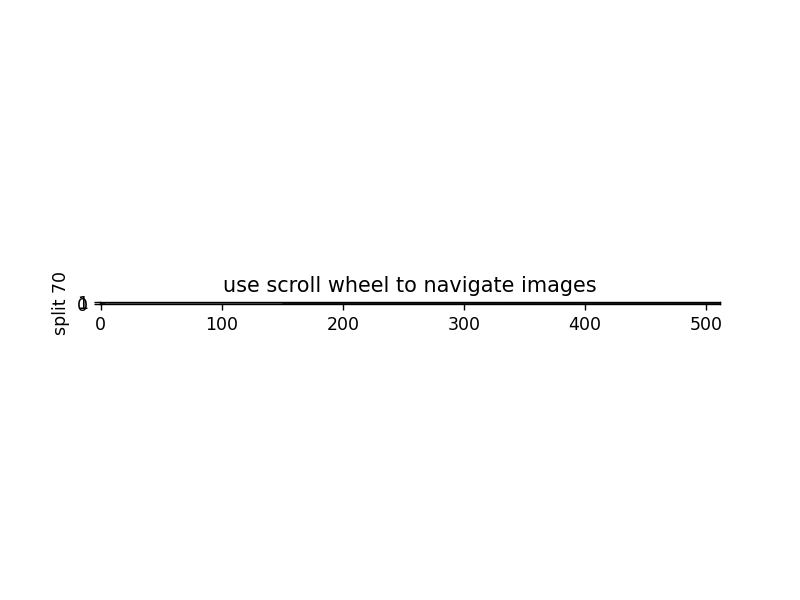

In [125]:
frame_height = 512
frame_width = 512

## 24-48h
centerx = 248
centery = 245
radius = 150

## 12-24h
# centerx = 115
# centery = 200
# radius = 20
t_str = "t15"

zsz = metadata["dimensions"]["Z"]["NumberOfElements"]

zar = np.arange(0,zsz)
img_seq = get_image_sequence(video_folder, exp_name, acq_name, t_str)
roi_image = img_seq[:, :, 0]
height,width = roi_image.shape
img_seq_maxz = np.zeros((height, width, zsz)) # numpy 3d array image sequence to track max intensity images
Rar_pxl = np.arange(5,width/2, dr, dtype=np.int32)
for zix in range(zsz):
    roi_image = img_seq[:, :, zix]
    blurred_image = cv2.GaussianBlur(roi_image, (15,15), 0).astype(np.uint8)
    cv2.circle(blurred_image, (centerx, centery), radius, (255,255,255), 1)
    img_seq_maxz[:,:,zix] = blurred_image
    
# Plot the image sequence in a figure
fig_maxint_img, ax = plt.subplots()
tracker = tr.IndexTracker(ax, img_seq_maxz, "image", 150)#, args_dict)

fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

## Calculate central sum and test for each z value
At the end, calculate the ROI from the center point +- radius*1.1 square.

<IPython.core.display.Javascript object>


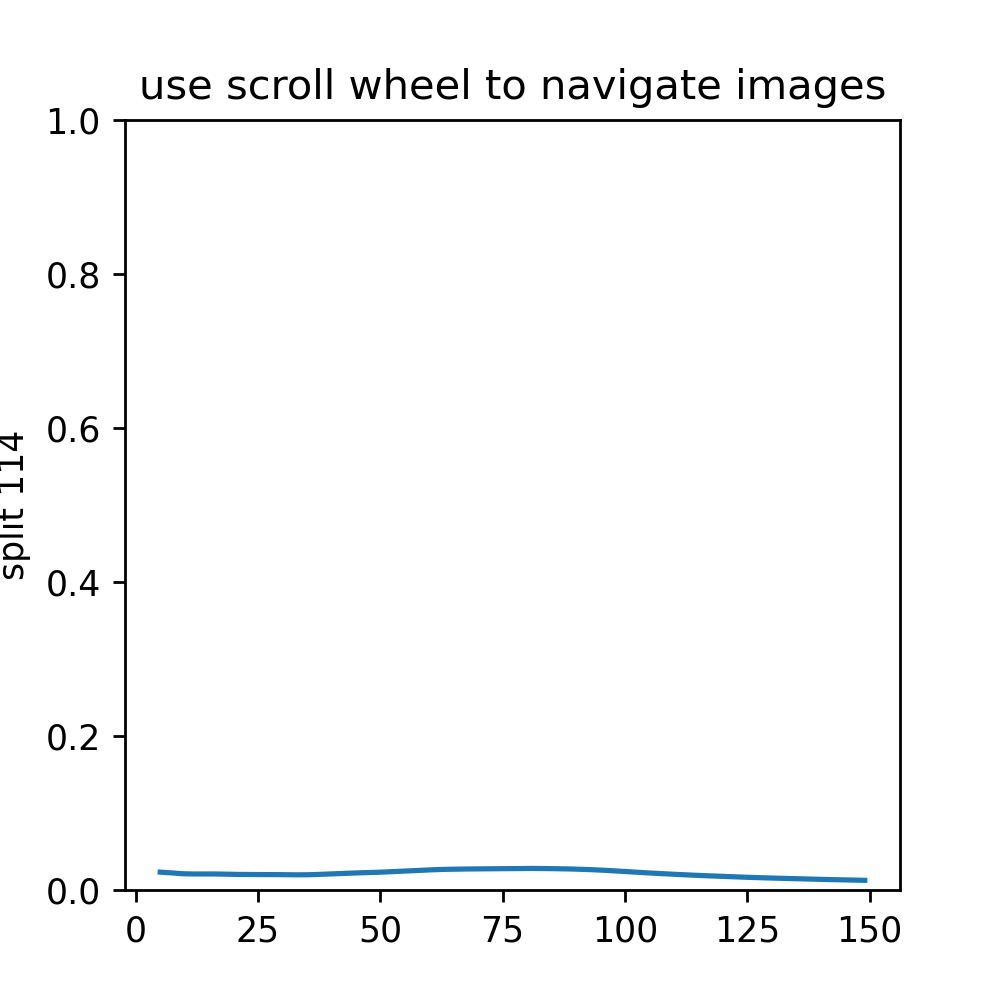

In [128]:
roix = np.array([centerx - radius, centerx + radius], dtype=np.int32)
roiy = np.array([centery - radius, centery + radius], dtype=np.int32)

roi_image = img_seq[roiy[0]:roiy[1], roix[0]:roix[1], 0]
height,width = roi_image.shape
img_seq_maxz = np.zeros((height, width, zsz)) # numpy 3d array image sequence to track max intensity images
Rar_pxl = np.arange(5,width/2, dr, dtype=np.int32)
plt_seq = np.zeros((2,len(Rar_pxl), zsz))
for zix in range(zsz):
    roi_image = img_seq[roiy[0]:roiy[1], roix[0]:roix[1], zix]
    blurred_image = cv2.GaussianBlur(roi_image, (15,15), 0).astype(np.uint8)
    # Use blurred_image for nice plots
    if zix%10 == 0:
        print(f"Calculating zix = {zix}/{zsz}", end="\r", flush=True)
    img_seq_maxz[:, :, zix] = blurred_image

    central_avg = collect_radial_data(blurred_image, Rar_pxl)
    plt_seq[0,:,zix] = Rar_pxl.copy()
    plt_seq[1,:,zix] = central_avg.copy()
    
fig_maxint_img, ax = plt.subplots(figsize=(4,4), dpi=200)
tracker = tr.IndexTracker(ax, plt_seq, "line", 70)
#     ax.set_xlim(0,40)
ax.set_ylim(0,1)
ax.set_xlabel("Radius (pxl)")
ax.set_ylabel("Average pixel brightness")
fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

### Collect the rmax(z) and cvmax(z).

<IPython.core.display.Javascript object>


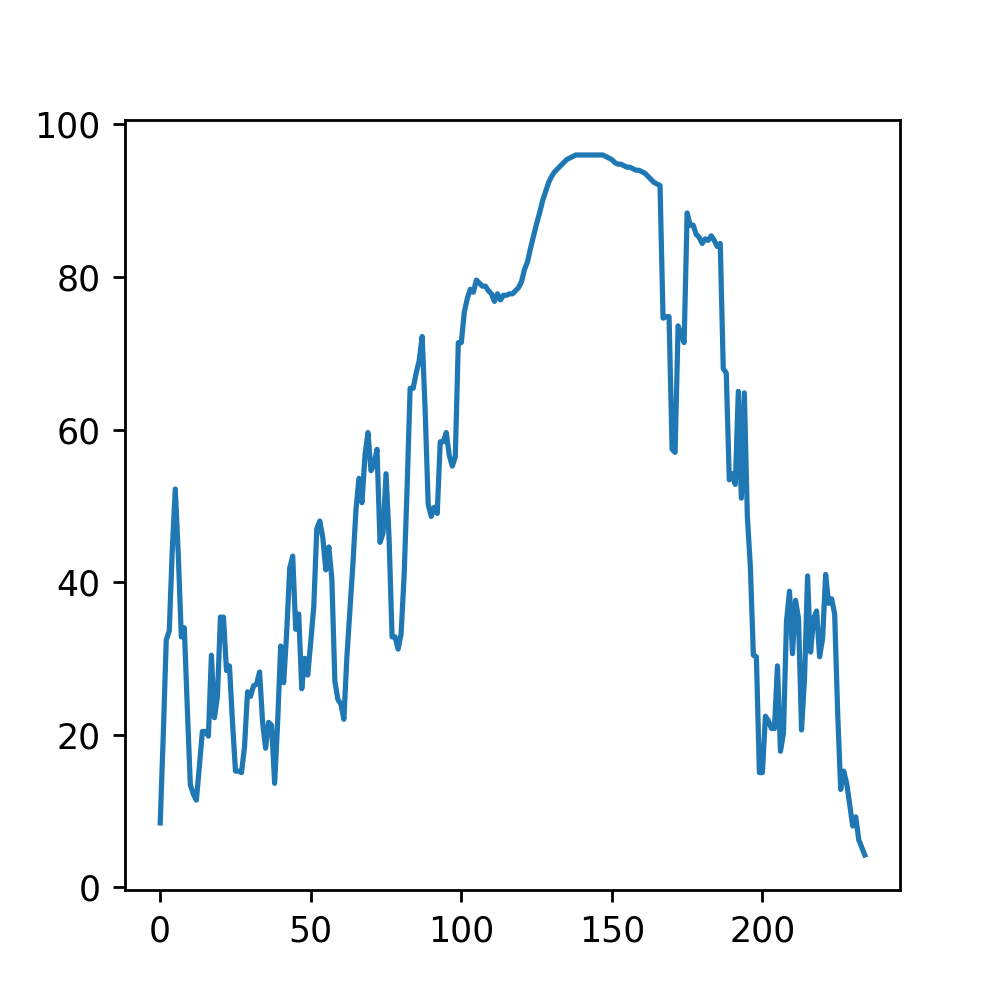

In [132]:
def window(size):
    return np.ones(size)/float(size)

window_average = 5

# Check the central sum for height measurement

# Choose above 0.1 central average (10% filled)
rmax = np.zeros(zsz)
cmax = np.zeros(zsz)
for zix in range(zsz):
    rad = plt_seq[0,:,zix]
    cav = plt_seq[1,:,zix]
    
    cavmax = np.max(cav)   # maximum value of the central average
    cavmaxarg = np.argmax(cav)  # index of the maximum central average value
    
    rmax[zix] = rad[cavmaxarg]
    cmax[zix] = cavmax
    
    
fig,ax = plt.subplots(figsize=(4,4), dpi=200)
ax.plot(zar, np.convolve(rmax, window(window_average), 'same'))
# ax.plot(zar, rmax)

<IPython.core.display.Javascript object>


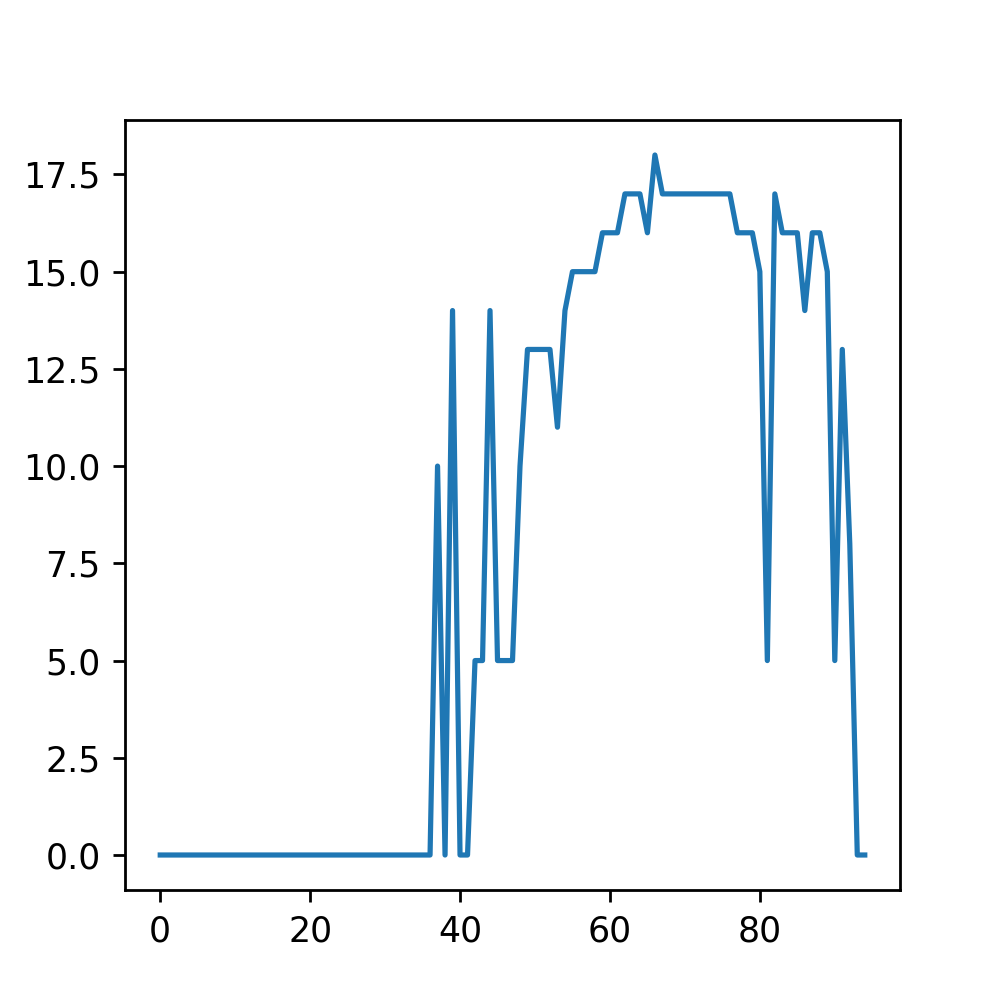